# 1. Setup and Data Loading

Import necessary libraries and load the dataset. We'll filter the columns
to keep only the relevant ones identified.

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from pandas.tseries.offsets import Day
import warnings

# Optional: Configure settings for better display
pd.set_option('display.max_columns', 50)
warnings.filterwarnings('ignore', category=FutureWarning) # Ignore future warnings from seaborn/pandas

In [34]:

df = pd.read_csv(r'G:\Users\Clamfighter\Documents\GitHub\Football-Analytics\Data\football_data.csv', low_memory=False)



columns_to_keep = [
    "Div", "Date", "Time", "HomeTeam", "AwayTeam",
    "FTHG", "HG", "FTAG", "AG", "FTR", "Res", # Full Time Goals and Result
    "HTHG", "HTAG", "HTR",                 # Half Time Goals and Result
    "Attendance", "Referee",               # Match Info
    "HS", "AS", "HST", "AST", "HHW", "AHW", # Shots and Woodwork
    "HC", "AC",                            # Corners
    "HF", "AF", "HFKC", "AFKC",             # Fouls and Free Kicks Conceded
    "HO", "AO",                            # Offsides
    "HY", "AY", "HR", "AR",                 # Cards
    "HBP", "ABP"                           # Booking Points
]

# Filter columns that actually exist in the loaded DataFrame
columns_in_df = [col for col in columns_to_keep if col in df.columns]
df_filtered = df[columns_in_df].copy() # Use a copy to avoid SettingWithCopyWarning

# --- Data Cleaning: Handle potential alias columns ---
# Use FTHG if available, otherwise HG. Create FTHG if only HG exists.
if 'FTHG' not in df_filtered.columns and 'HG' in df_filtered.columns:
    df_filtered['FTHG'] = df_filtered['HG']
if 'FTAG' not in df_filtered.columns and 'AG' in df_filtered.columns:
    df_filtered['FTAG'] = df_filtered['AG']
if 'FTR' not in df_filtered.columns and 'Res' in df_filtered.columns:
    df_filtered['FTR'] = df_filtered['Res']

# Ensure essential columns exist after aliasing
essential_cols = ["Div", "Date", "Time", "HomeTeam", "AwayTeam", "FTHG", "FTAG", "FTR"]
missing_essentials = [col for col in essential_cols if col not in df_filtered.columns]
if missing_essentials:
    raise ValueError(f"Essential columns missing from the dataset: {missing_essentials}")

# --- Data Cleaning: Convert goal columns to numeric ---
goal_cols = ['FTHG', 'FTAG', 'HTHG', 'HTAG']
for col in goal_cols:
    if col in df_filtered.columns:
        df_filtered[col] = pd.to_numeric(df_filtered[col], errors='coerce') # Convert to number, turn errors into NaN

# Drop rows where essential goal information is missing
df_filtered.dropna(subset=['FTHG', 'FTAG'], inplace=True)

print(f"\nFiltered DataFrame shape: {df_filtered.shape}")
print("Available columns after filtering:")
print(df_filtered.columns)

print("\nSample of filtered data:")
df_filtered


Filtered DataFrame shape: (55666, 36)
Available columns after filtering:
Index(['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'HG', 'FTAG',
       'AG', 'FTR', 'Res', 'HTHG', 'HTAG', 'HTR', 'Attendance', 'Referee',
       'HS', 'AS', 'HST', 'AST', 'HHW', 'AHW', 'HC', 'AC', 'HF', 'AF', 'HFKC',
       'AFKC', 'HO', 'AO', 'HY', 'AY', 'HR', 'AR', 'HBP', 'ABP'],
      dtype='object')

Sample of filtered data:


,Div,Date,Time,HomeTeam,AwayTeam,FTHG,HG,FTAG,AG,FTR,Res,HTHG,HTAG,HTR,Attendance,Referee,HS,AS,HST,AST,HHW,AHW,HC,AC,HF,AF,HFKC,AFKC,HO,AO,HY,AY,HR,AR,HBP,ABP
0,E0,11/08/2023,20:00,Burnley,Man City,0.0,NaN,3.0,NaN,A,NaN,0.0,2.0,A,NaN,C Pawson,6.0,17.0,1.0,8.0,NaN,NaN,6.0,5.0,11.0,8.0,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,NaN,NaN
1,E0,12/08/2023,12:30,Arsenal,Nott'm Forest,2.0,NaN,1.0,NaN,H,NaN,2.0,0.0,H,NaN,M Oliver,15.0,6.0,7.0,2.0,NaN,NaN,8.0,3.0,12.0,12.0,NaN,NaN,NaN,NaN,2.0,2.0,0.0,0.0,NaN,NaN
2,E0,12/08/2023,15:00,Bournemouth,West Ham,1.0,NaN,1.0,NaN,D,NaN,0.0,0.0,D,NaN,P Bankes,14.0,16.0,5.0,3.0,NaN,NaN,10.0,4.0,9.0,14.0,NaN,NaN,NaN,NaN,1.0,4.0,0.0,0.0,NaN,NaN
3,E0,12/08/2023,15:00,Brighton,Luton,4.0,NaN,1.0,NaN,H,NaN,1.0,0.0,H,NaN,D Coote,27.0,9.0,12.0,3.0,NaN,NaN,6.0,7.0,11.0,12.0,NaN,NaN,NaN,NaN,2.0,2.0,0.0,0.0,NaN,NaN
4,E0,12/08/2023,15:00,Everton,Fulham,0.0,NaN,1.0,NaN,A,NaN,0.0,0.0,D,NaN,S Attwell,19.0,9.0,9.0,2.0,NaN,NaN,10.0,4.0,12.0,6.0,NaN,NaN,NaN,NaN,0.0,2.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55678,NaN,25/03/2025,19:45,Altrincham,Solihull,1.0,NaN,1.0,NaN,D,NaN,1.0,0.0,H,NaN,J Westgate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,1.0,0.0,NaN,NaN
55679,NaN,25/03/2025,19:45,Boston Utd,Southend,3.0,NaN,0.0,NaN,H,NaN,0.0,0.0,D,NaN,N Smith,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0.0,0.0,0.0,NaN,NaN
55680,NaN,25/03/2025,19:45,Rochdale,York,0.0,NaN,4.0,NaN,A,NaN,0.0,1.0,A,NaN,G Rollason,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,0.0,0.0,NaN,NaN
55681,NaN,25/03/2025,19:45,Wealdstone,Aldershot,1.0,NaN,3.0,NaN,A,NaN,1.0,0.0,H,NaN,R Atkin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,0.0,0.0,NaN,NaN


# 2. Data Transformation


## 2.1. Data Transformation: Match-level to Team-level

The original data is one row per match. To analyze team performance and calculate autoregressive features (like rolling averages), it's better to have one row per team *per match*. We'll transform the data accordingly.

In [35]:
shared_cols = ['Div', 'Date', 'Time', 'Referee', 'Attendance', 'HTR', 'FTR']
shared_cols = [col for col in shared_cols if col in df_filtered.columns]

# Define mappings using actual column names present in df_filtered
home_stat_cols = {
    'Team': 'HomeTeam', 'Opponent': 'AwayTeam', 'Goals': 'FTHG', 'GoalsConceded': 'FTAG',
    'HTGoals': 'HTHG', 'HTGoalsConceded': 'HTAG',
    'Shots': 'HS', 'ShotsOnTarget': 'HST', 'HitWoodwork': 'HHW', 'Corners': 'HC',
    'Fouls': 'HF', 'FreeKicksConceded': 'HFKC', 'Offsides': 'HO',
    'YellowCards': 'HY', 'RedCards': 'HR', 'BookingPoints': 'HBP'
}

away_stat_cols = {
    'Team': 'AwayTeam', 'Opponent': 'HomeTeam', 'Goals': 'FTAG', 'GoalsConceded': 'FTHG',
    'HTGoals': 'HTAG', 'HTGoalsConceded': 'HTHG',
    'Shots': 'AS', 'ShotsOnTarget': 'AST', 'HitWoodwork': 'AHW', 'Corners': 'AC',
    'Fouls': 'AF', 'FreeKicksConceded': 'AFKC', 'Offsides': 'AO',
    'YellowCards': 'AY', 'RedCards': 'AR', 'BookingPoints': 'ABP'
}

# Filter mappings to only include columns present in df_filtered
home_stat_cols_present = {k: v for k, v in home_stat_cols.items() if v in df_filtered.columns}
away_stat_cols_present = {k: v for k, v in away_stat_cols.items() if v in df_filtered.columns}

# Extract dataframes
home_df = df_filtered[shared_cols + list(home_stat_cols_present.values())].copy()
home_df.columns = shared_cols + list(home_stat_cols_present.keys())
home_df["IsHome"] = True # Add indicator for home advantage

away_df = df_filtered[shared_cols + list(away_stat_cols_present.values())].copy()
away_df.columns = shared_cols + list(away_stat_cols_present.keys())
away_df["IsHome"] = False # Add indicator for home advantage

# Combine home and away perspectives
team_df = pd.concat([home_df, away_df], ignore_index=True)

# --- Data Cleaning and Sorting ---
# Convert Date column to datetime objects
team_df['Date'] = pd.to_datetime(team_df['Date'], dayfirst=True, errors='coerce')

# Convert Time column to datetime objects, handling potential errors
team_df['Time'] = pd.to_datetime(team_df['Time'], format='%H:%M', errors='coerce').dt.time # Keep only time part


# Drop rows where Date conversion failed
team_df.dropna(subset=['Date'], inplace=True)

# Sort data chronologically per team - ESSENTIAL for time series features
team_df = team_df.sort_values(by=['Team', 'Date', 'Time']).reset_index(drop=True)

# Convert relevant stat columns to numeric, coercing errors
stat_cols_to_numeric = [
    'Goals', 'GoalsConceded', 'HTGoals', 'HTGoalsConceded', 'Shots',
    'ShotsOnTarget', 'HitWoodwork', 'Corners', 'Fouls', 'FreeKicksConceded',
    'Offsides', 'YellowCards', 'RedCards', 'BookingPoints', 'Attendance'
]
for col in stat_cols_to_numeric:
    if col in team_df.columns:
        team_df[col] = pd.to_numeric(team_df[col], errors='coerce')

print(f"\nTransformed {df_filtered.shape[0]} matches --> {team_df.shape[0]} team-rows")
print("\nData types of team-level data:")
print(team_df.info())
team_df


Transformed 55666 matches --> 111332 team-rows

Data types of team-level data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111332 entries, 0 to 111331
Data columns (total 24 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Div                107108 non-null  object        
 1   Date               111332 non-null  datetime64[ns]
 2   Time               29132 non-null   object        
 3   Referee            106870 non-null  object        
 4   Attendance         8136 non-null    float64       
 5   HTR                111330 non-null  object        
 6   FTR                111332 non-null  object        
 7   Team               111332 non-null  object        
 8   Opponent           111332 non-null  object        
 9   Goals              111332 non-null  float64       
 10  GoalsConceded      111332 non-null  float64       
 11  HTGoals            111330 non-null  float64       
 12  HTGoalsConceded    1

,Div,Date,Time,Referee,Attendance,HTR,FTR,Team,Opponent,Goals,GoalsConceded,HTGoals,HTGoalsConceded,Shots,ShotsOnTarget,HitWoodwork,Corners,Fouls,FreeKicksConceded,Offsides,YellowCards,RedCards,BookingPoints,IsHome
0,EC,2011-08-16,NaT,R Whitton,NaN,D,H,AFC Telford United,Cambridge,0.0,1.0,0.0,0.0,12.0,5.0,NaN,4.0,10.0,NaN,NaN,2.0,0.0,NaN,False
1,EC,2011-08-20,NaT,T Harrington,NaN,D,A,AFC Telford United,York,1.0,0.0,0.0,0.0,5.0,2.0,NaN,2.0,11.0,NaN,NaN,1.0,0.0,NaN,False
2,EC,2011-08-23,NaT,D Bond,NaN,D,A,AFC Telford United,Lincoln,1.0,2.0,0.0,0.0,8.0,6.0,NaN,5.0,15.0,NaN,NaN,2.0,0.0,NaN,True
3,EC,2011-08-27,NaT,P Banks,NaN,D,H,AFC Telford United,Newport County,2.0,1.0,1.0,1.0,9.0,4.0,NaN,1.0,10.0,NaN,NaN,2.0,0.0,NaN,True
4,EC,2011-08-29,NaT,D Handley,NaN,H,D,AFC Telford United,Tamworth,2.0,2.0,0.0,1.0,12.0,5.0,NaN,1.0,13.0,NaN,NaN,3.0,0.0,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111327,NaN,2025-03-04,19:45:00,J O'Connor,NaN,A,A,York,Altrincham,1.0,2.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,NaN,True
111328,NaN,2025-03-08,17:30:00,O Yates,NaN,D,D,York,Forest Green,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,True
111329,NaN,2025-03-15,15:00:00,A Farmer,NaN,D,A,York,Yeovil,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0.0,NaN,False
111330,NaN,2025-03-22,15:00:00,C Walchester,NaN,D,H,York,Braintree Town,1.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,False


## 2.2 Compute Running League Points & Opponent Rankings

In [36]:
# Calculate match points based on full time result
def calc_points(result):
    if result == 'W':  # Update this depending on how wins are coded in your FTR
        return 3
    elif result == 'D':
        return 1
    else:
        return 0

team_df['Points'] = team_df['FTR'].apply(calc_points)
team_df['CumulativePoints'] = team_df.sort_values(by=['Date', 'Time']).groupby('Team')['Points'].cumsum()

# Rank teams by cumulative points on each matchday and split into thirds.
def assign_league_third(group):
    group = group.sort_values(by='CumulativePoints', ascending=False)
    total = len(group)
    group['LeaguePosition'] = ['Top' if i < total/3 
                               else 'Middle' if i < 2*total/3 
                               else 'Bottom' 
                               for i in range(total)]
    return group

# Group by match date (or matchday if available) and assign positions across all divisions
team_df = team_df.groupby('Date').apply(assign_league_third).reset_index(drop=True)


C:\Users\Jack\AppData\Local\Temp\ipykernel_36620\1736797701.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  team_df = team_df.groupby('Date').apply(assign_league_third).reset_index(drop=True)


## 2.3 Calculate Results  

In [39]:
def team_result(row):
    if row['IsHome']:
        if row['FTR'] == 'H':
            return 'W'
        elif row['FTR'] == 'D':
            return 'D'
        else:
            return 'L'
    else:
        if row['FTR'] == 'A':
            return 'W'
        elif row['FTR'] == 'D':
            return 'D'
        else:
            return 'L'

team_df['Result'] = team_df.apply(team_result, axis=1)
team_df = team_df.sort_values(by=['Team', 'Date', 'Time']).reset_index(drop=True)
team_df['NextOutcome'] = team_df.groupby('Team')['Result'].shift(-1)



## 2.4 Calculate Streaks

In [40]:
def add_multiple_streaks(group):
    win_streak = []
    unbeaten_streak = []
    loss_streak = []
    no_wins_streak = []
    
    current_win_streak = 0
    current_unbeaten_streak = 0
    current_loss_streak = 0
    current_no_wins_streak = 0
    
    # Iterate over the team's matches using the recoded "Result"
    for result in group['Result']:
        # WinStreak: increment if win, else reset
        if result == 'W':
            current_win_streak += 1
        else:
            current_win_streak = 0
        win_streak.append(current_win_streak)
        
        # UnbeatenStreak: increment if not a loss (win or draw), else reset
        if result != 'L':
            current_unbeaten_streak += 1
        else:
            current_unbeaten_streak = 0
        unbeaten_streak.append(current_unbeaten_streak)
        
        # LossStreak: increment if loss, else reset
        if result == 'L':
            current_loss_streak += 1
        else:
            current_loss_streak = 0
        loss_streak.append(current_loss_streak)
        
        # NoWinsStreak: increment if not a win (draw or loss), else reset
        if result != 'W':
            current_no_wins_streak += 1
        else:
            current_no_wins_streak = 0
        no_wins_streak.append(current_no_wins_streak)
    
    group = group.copy()  # avoid modifying the original group
    group['WinStreak'] = win_streak
    group['UnbeatenStreak'] = unbeaten_streak
    group['LossStreak'] = loss_streak
    group['NoWinsStreak'] = no_wins_streak
    return group

# Apply the streak computation for each team
team_df = team_df.groupby('Team').apply(add_multiple_streaks).reset_index(drop=True)


C:\Users\Jack\AppData\Local\Temp\ipykernel_36620\606963333.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  team_df = team_df.groupby('Team').apply(add_multiple_streaks).reset_index(drop=True)


In [41]:
team_df.sort_values('WinStreak',ascending=False).head(1)

,Div,Date,Time,Referee,Attendance,HTR,FTR,Team,Opponent,Goals,GoalsConceded,HTGoals,HTGoalsConceded,Shots,ShotsOnTarget,HitWoodwork,Corners,Fouls,FreeKicksConceded,Offsides,YellowCards,RedCards,BookingPoints,IsHome,Points,CumulativePoints,LeaguePosition,Result,NextOutcome,WinStreak,UnbeatenStreak,LossStreak,NoWinsStreak
57759,E0,2020-02-24,20:00:00,J Moss,NaN,D,H,Liverpool,West Ham,3.0,2.0,1.0,1.0,25.0,7.0,NaN,16.0,4.0,NaN,NaN,0.0,0.0,NaN,True,0,161,Middle,W,L,18,44,0,0


In [42]:
team_df.sort_values('UnbeatenStreak',ascending=False).head(1)

,Div,Date,Time,Referee,Attendance,HTR,FTR,Team,Opponent,Goals,GoalsConceded,HTGoals,HTGoalsConceded,Shots,ShotsOnTarget,HitWoodwork,Corners,Fouls,FreeKicksConceded,Offsides,YellowCards,RedCards,BookingPoints,IsHome,Points,CumulativePoints,LeaguePosition,Result,NextOutcome,WinStreak,UnbeatenStreak,LossStreak,NoWinsStreak
57759,E0,2020-02-24,20:00:00,J Moss,NaN,D,H,Liverpool,West Ham,3.0,2.0,1.0,1.0,25.0,7.0,NaN,16.0,4.0,NaN,NaN,0.0,0.0,NaN,True,0,161,Middle,W,L,18,44,0,0


In [43]:
team_df.sort_values('NoWinsStreak',ascending=False).head(1)

,Div,Date,Time,Referee,Attendance,HTR,FTR,Team,Opponent,Goals,GoalsConceded,HTGoals,HTGoalsConceded,Shots,ShotsOnTarget,HitWoodwork,Corners,Fouls,FreeKicksConceded,Offsides,YellowCards,RedCards,BookingPoints,IsHome,Points,CumulativePoints,LeaguePosition,Result,NextOutcome,WinStreak,UnbeatenStreak,LossStreak,NoWinsStreak
35524,E1,2008-08-30,NaT,G Salisbury,NaN,D,H,Derby,Barnsley,0.0,2.0,0.0,0.0,12.0,6.0,NaN,7.0,19.0,NaN,NaN,1.0,0.0,NaN,False,0,69,Top,L,W,0,0,2,36


In [44]:
team_df.sort_values('LossStreak',ascending=False).head(1)

,Div,Date,Time,Referee,Attendance,HTR,FTR,Team,Opponent,Goals,GoalsConceded,HTGoals,HTGoalsConceded,Shots,ShotsOnTarget,HitWoodwork,Corners,Fouls,FreeKicksConceded,Offsides,YellowCards,RedCards,BookingPoints,IsHome,Points,CumulativePoints,LeaguePosition,Result,NextOutcome,WinStreak,UnbeatenStreak,LossStreak,NoWinsStreak
55093,EC,2009-03-28,NaT,W Barratt,NaN,H,H,Lewes,Forest Green,1.0,4.0,1.0,2.0,5.0,2.0,NaN,1.0,6.0,NaN,NaN,1.0,2.0,NaN,False,0,5,Bottom,L,W,0,0,18,18


# 3. Calculating Probabilities

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_streak_outcome_probs(df, streak_columns, max_streak_length=7):
    """
    Generate outcome probability visuals (bar + stacked area) for each streak column.

    Parameters:
    - df: DataFrame with 'NextOutcome' and the streak columns
    - streak_columns: list of streak column names (e.g., ['WinStreak', 'NoLossStreak_viz'])
    - max_streak_length: max streak length to include in plots
    """

    # Style setup
    sns.set_style("whitegrid")
    sns.set_context("talk", font_scale=0.9)

    outcomes = ['W', 'D', 'L']
    colors = {'W': '#55A868', 'D': '#CFCFCF', 'L': '#C44E52'}
    labels = {'W': 'Win', 'D': 'Draw', 'L': 'Loss'}

    for streak_col in streak_columns:
        # --- Step 1: Calculate conditional probabilities ---
        results_table = {}
        for s in range(0, max_streak_length + 1):
            filtered = df[df[streak_col] == s]
            results_table[s] = filtered['NextOutcome'].value_counts(normalize=True)

        # --- Step 2: Convert to DataFrame ---
        df_probs = pd.DataFrame(results_table).T.fillna(0)
        df_probs = df_probs[['W', 'D', 'L']].sort_index()
        streaks = df_probs.index
        x = np.arange(len(streaks))
        width = 0.25

        # --- Chart 1: Grouped Bar Chart ---
        fig, ax = plt.subplots(figsize=(10, 6))

        for i, outcome in enumerate(outcomes):
            ax.bar(x + i * width - width, df_probs[outcome],
                   width=width, label=labels[outcome],
                   color=colors[outcome], edgecolor='white', linewidth=0.6, alpha=0.9)

        ax.set_title(f"Match Outcome by {streak_col}", fontsize=16, weight='bold')
        ax.set_xlabel(f"{streak_col} Length", fontsize=12)
        ax.set_ylabel("Probability", fontsize=12)
        ax.set_xticks(x)
        ax.set_xticklabels(streaks)
        ax.set_ylim(0, 1.0)
        ax.grid(axis='y', alpha=0.2)
        ax.tick_params(labelsize=11)
        sns.despine()

        ax.legend(
            title='Next Result',
            frameon=False,
            loc='center left',
            bbox_to_anchor=(1.02, 0.5),
            borderaxespad=0,
            fontsize=11
        )

        plt.tight_layout()
        plt.show()

        # --- Chart 2: Stacked Area Chart ---
        fig, ax = plt.subplots(figsize=(10, 6))

        stack_vals = np.vstack([df_probs[o] for o in outcomes])
        cumulative = np.cumsum(stack_vals, axis=0)

        for i, outcome in enumerate(outcomes):
            base = cumulative[i - 1] if i > 0 else np.zeros_like(streaks)
            ax.fill_between(streaks, base, cumulative[i],
                            label=labels[outcome],
                            color=colors[outcome], alpha=0.85)

        ax.set_title(f"Outcome Share by {streak_col} (100%)", fontsize=16, weight='bold')
        ax.set_xlabel(f"{streak_col} Length", fontsize=12)
        ax.set_ylabel("Proportion of Outcomes", fontsize=12)
        ax.set_xticks(streaks)
        ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
        ax.set_ylim(0, 1.0)
        ax.grid(axis='y', alpha=0.2)
        ax.tick_params(labelsize=11)
        sns.despine()

        ax.legend(
            title='Next Result',
            frameon=False,
            loc='center left',
            bbox_to_anchor=(1.02, 0.5),
            borderaxespad=0,
            fontsize=11
        )

        plt.tight_layout()
        plt.show()


C:\Users\Jack\AppData\Local\Temp\ipykernel_36620\1319726413.py:65: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Jack\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


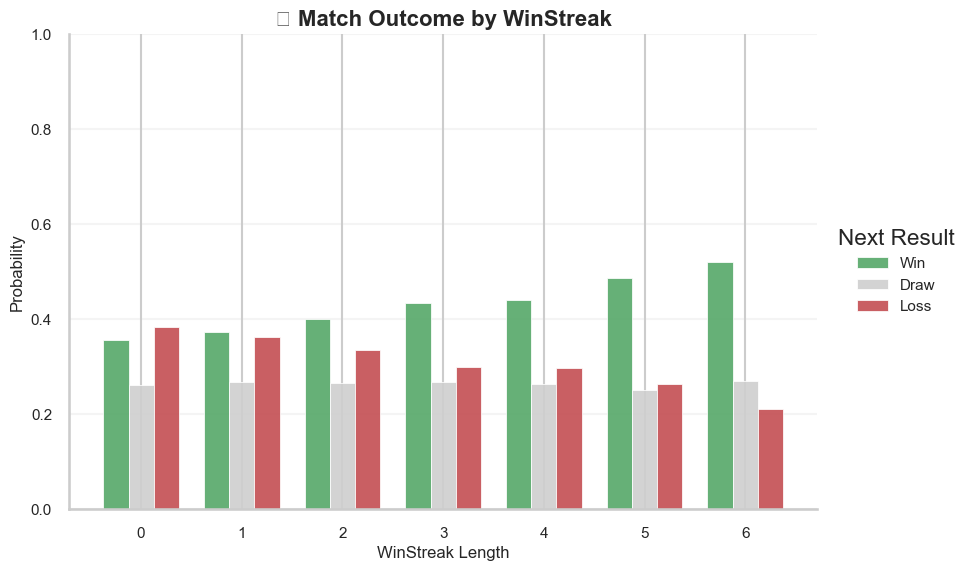

C:\Users\Jack\AppData\Local\Temp\ipykernel_36620\1319726413.py:99: UserWarning: Glyph 128999 (\N{LARGE ORANGE SQUARE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Jack\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128999 (\N{LARGE ORANGE SQUARE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


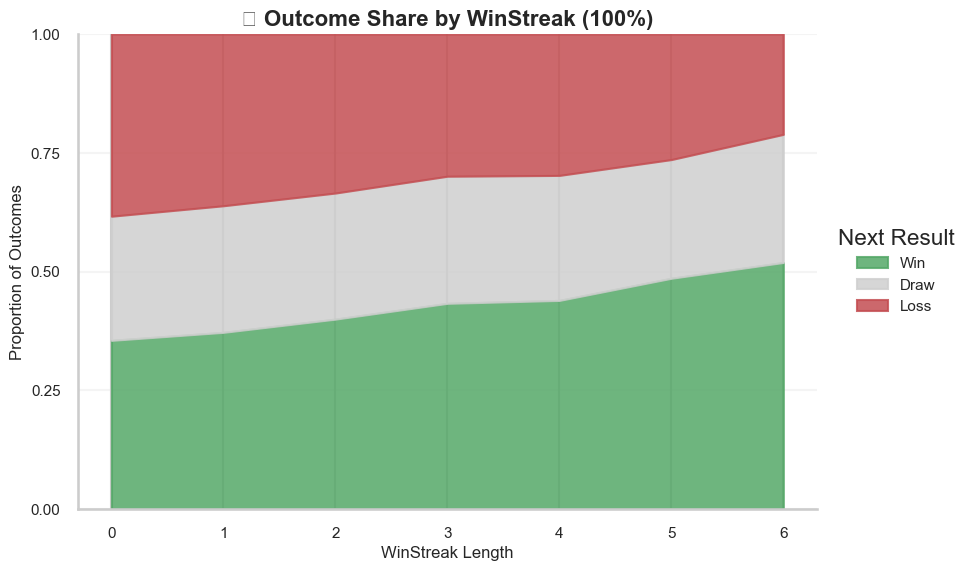

C:\Users\Jack\AppData\Local\Temp\ipykernel_36620\1319726413.py:65: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Jack\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


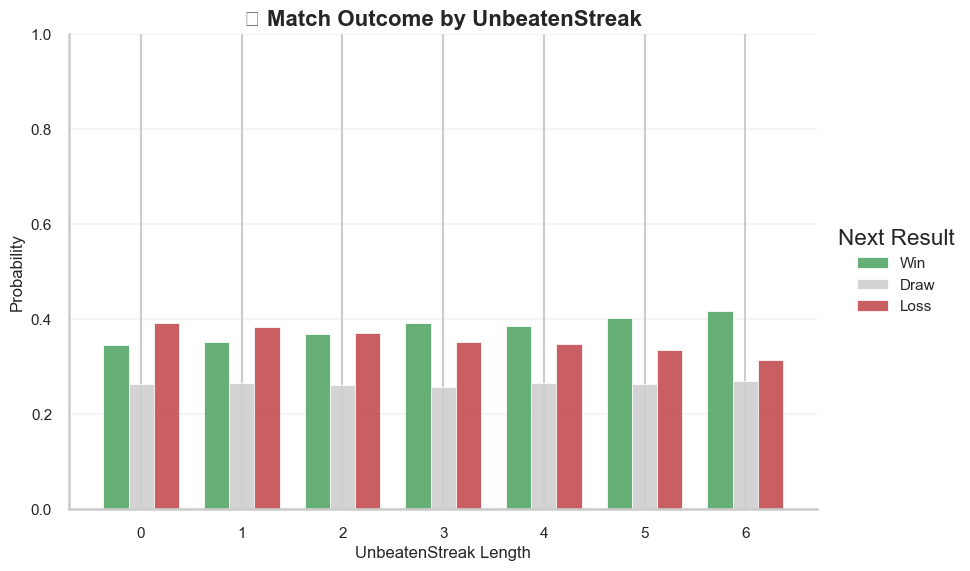

C:\Users\Jack\AppData\Local\Temp\ipykernel_36620\1319726413.py:99: UserWarning: Glyph 128999 (\N{LARGE ORANGE SQUARE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Jack\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128999 (\N{LARGE ORANGE SQUARE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


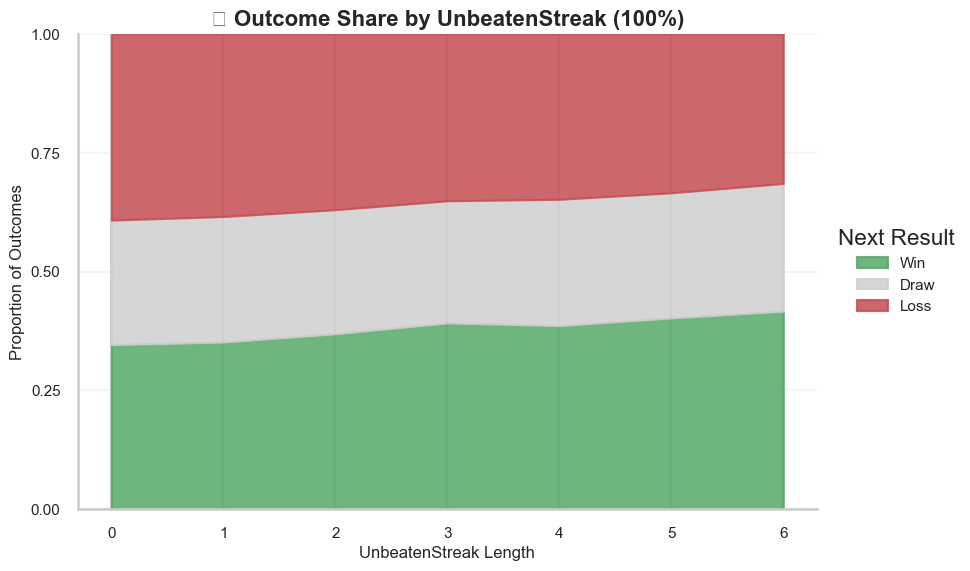

C:\Users\Jack\AppData\Local\Temp\ipykernel_36620\1319726413.py:65: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Jack\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


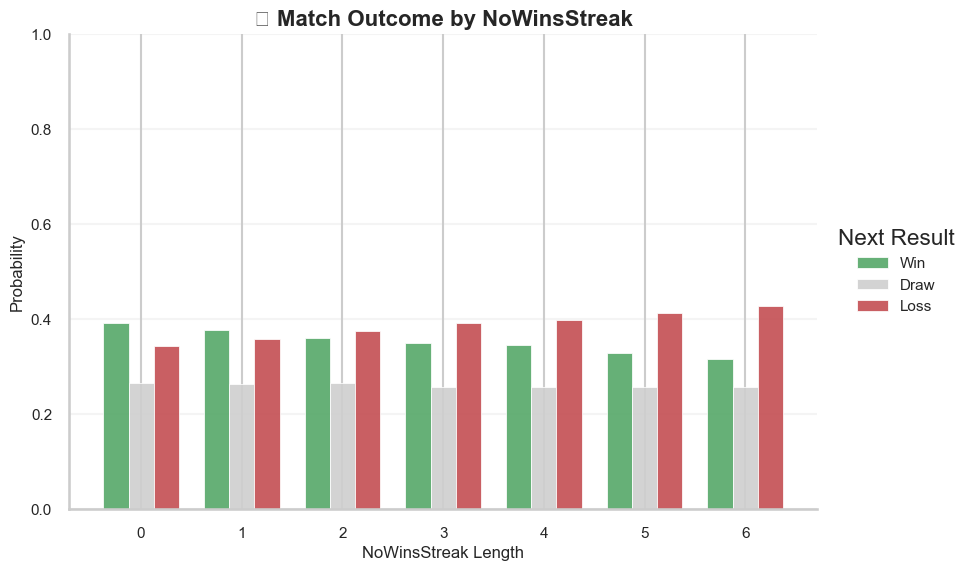

C:\Users\Jack\AppData\Local\Temp\ipykernel_36620\1319726413.py:99: UserWarning: Glyph 128999 (\N{LARGE ORANGE SQUARE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Jack\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128999 (\N{LARGE ORANGE SQUARE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


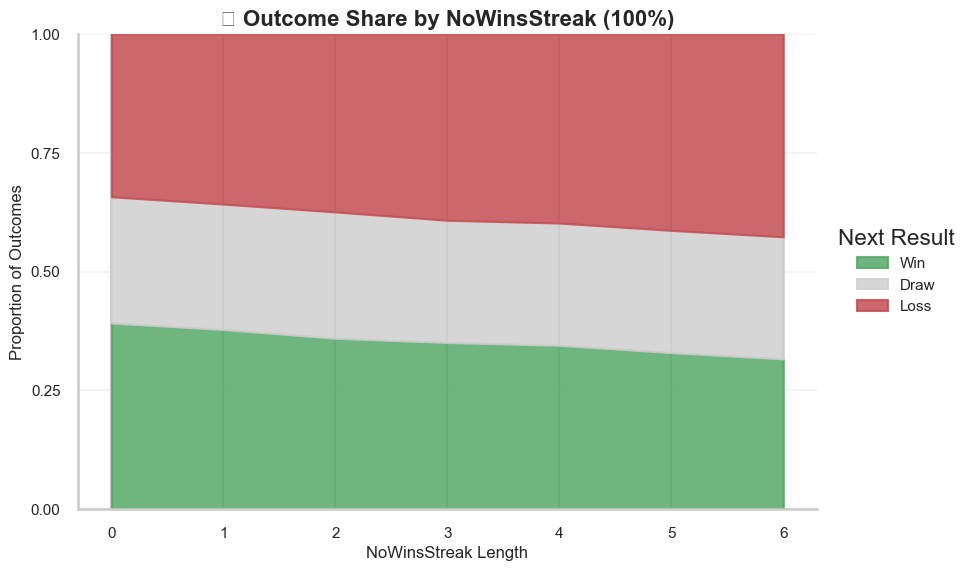

C:\Users\Jack\AppData\Local\Temp\ipykernel_36620\1319726413.py:65: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Jack\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


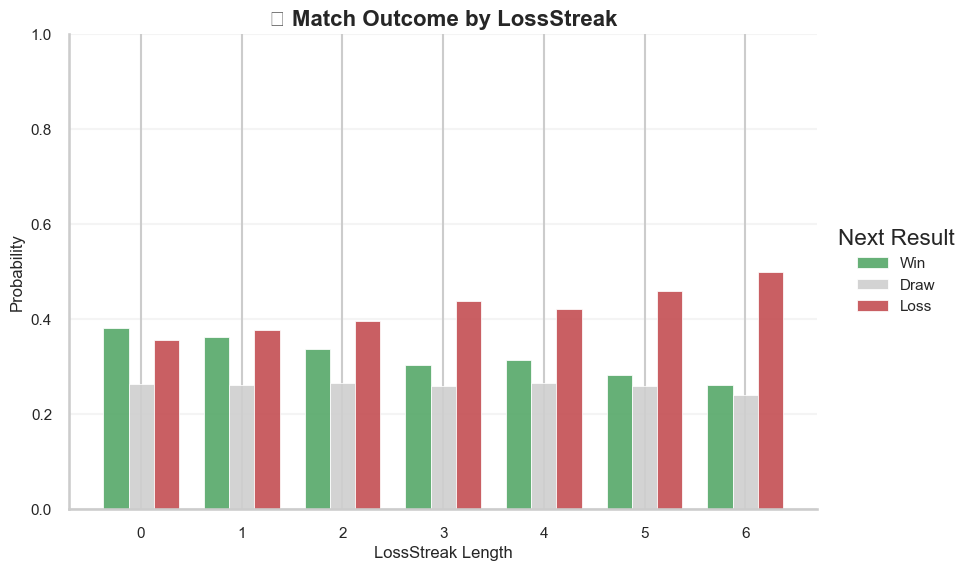

C:\Users\Jack\AppData\Local\Temp\ipykernel_36620\1319726413.py:99: UserWarning: Glyph 128999 (\N{LARGE ORANGE SQUARE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Jack\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128999 (\N{LARGE ORANGE SQUARE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


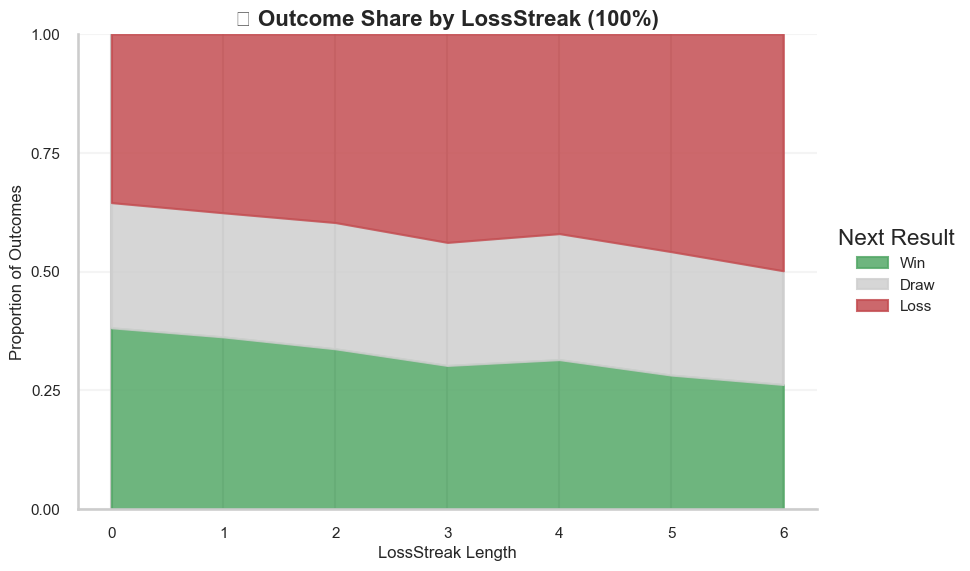

In [80]:
plot_streak_outcome_probs(team_df, ['WinStreak','UnbeatenStreak','NoWinsStreak','LossStreak'], max_streak_length=6)


In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_draw_trend_by_streak(df, streak_columns, max_streak_length=6):
    """
    Plot draw probabilities across streak lengths for each streak column provided.

    Parameters:
    - df: DataFrame with 'NextOutcome' and streak columns
    - streak_columns: list of column names representing streak types
    - max_streak_length: maximum streak length to analyze
    """
    sns.set_style("whitegrid")
    sns.set_context("talk", font_scale=0.9)

    for streak_col in streak_columns:
        draw_probs = {}
        for s in range(0, max_streak_length + 1):
            filtered = df[df[streak_col] == s]
            if not filtered.empty:
                draw_prob = filtered['NextOutcome'].value_counts(normalize=True).get('D', 0)
                draw_probs[s] = draw_prob
            else:
                draw_probs[s] = np.nan  # no data for that streak length

        # Convert to Series for plotting
        draw_series = pd.Series(draw_probs).sort_index()

        # Plot
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(draw_series.index, draw_series.values, marker='o', color='#CFCFCF', linewidth=2.5, label='Draw Probability')

        # Optional: draw average line
        avg = draw_series.mean(skipna=True)
        ax.axhline(avg, linestyle='--', color='#999999', linewidth=1.5, alpha=0.7, label=f'Avg: {avg:.1%}')

        # Styling
        ax.set_title(f"🟡 Draw Probability by {streak_col}", fontsize=16, weight='bold')
        ax.set_xlabel(f"{streak_col} Length", fontsize=12)
        ax.set_ylabel("Probability of Draw", fontsize=12)
        ax.set_ylim(0, 1.0)
        ax.set_xticks(draw_series.index)
        ax.grid(alpha=0.3)
        ax.tick_params(labelsize=11)
        sns.despine()

        # Legend
        ax.legend(frameon=False, loc='upper right', fontsize=11)

        plt.tight_layout()
        plt.show()


C:\Users\Jack\AppData\Local\Temp\ipykernel_36620\3079909928.py:52: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Jack\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


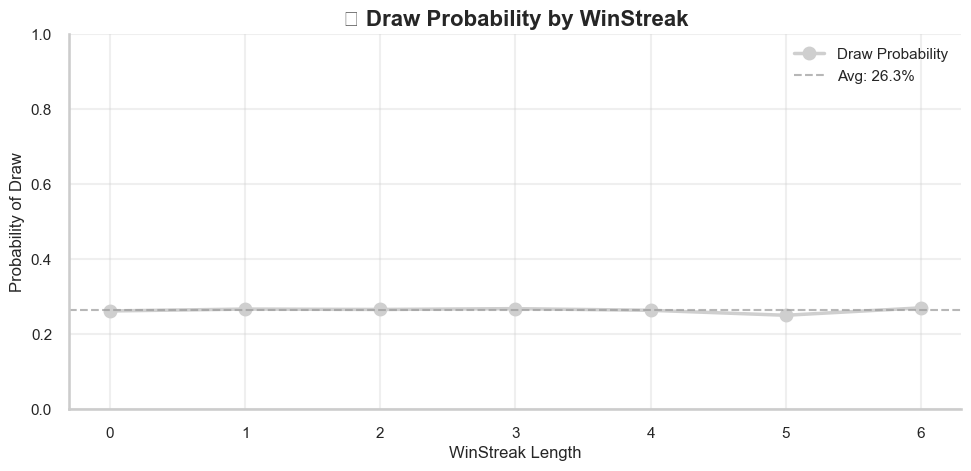

C:\Users\Jack\AppData\Local\Temp\ipykernel_36620\3079909928.py:52: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Jack\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


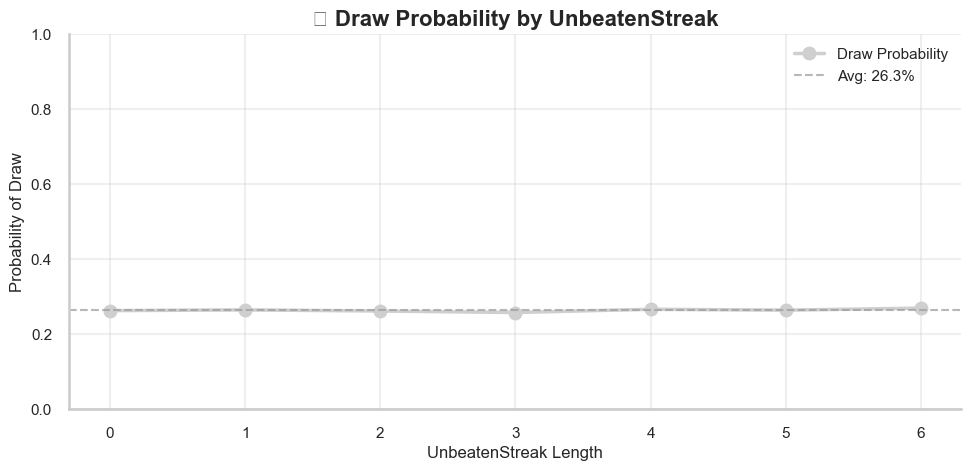

C:\Users\Jack\AppData\Local\Temp\ipykernel_36620\3079909928.py:52: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Jack\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


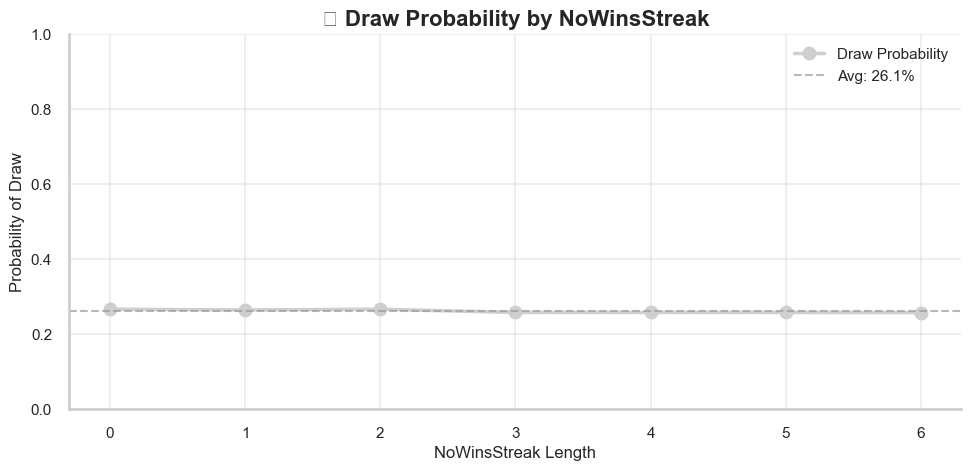

C:\Users\Jack\AppData\Local\Temp\ipykernel_36620\3079909928.py:52: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Jack\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


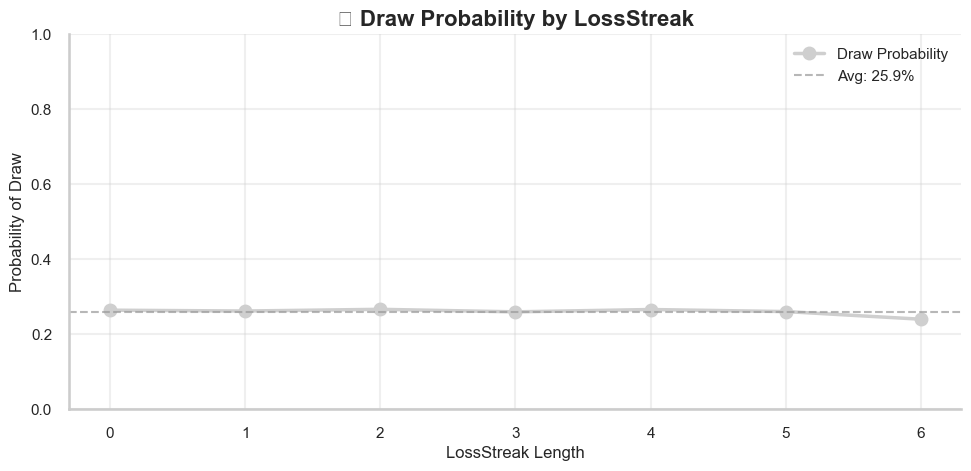

In [83]:
plot_draw_trend_by_streak(team_df, ['WinStreak','UnbeatenStreak','NoWinsStreak','LossStreak'], max_streak_length=6)
